In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import pickle
import numpy as np
lang_1 = pickle.load(open('data_pico_cohen.p', 'rb'))

In [23]:
lang_1['vocab_size'] = len(lang_1['word2idx'])
lang_1['word_dim'] = 200

In [24]:
for i, doc in enumerate(lang_1['cohen']) :
    new_sent = [sent for sent in doc if len(sent) > 0]
    lang_1['cohen'][i] = new_sent

In [25]:
import torch
import model
mod = model.Model(lang_1=lang_1, num_aspect=30)

In [26]:
mod.load_values('results/model_MonFeb1912:25:042018_pico_tanh')

In [27]:
embeds = []
attn = []
for doc in lang_1['cohen'] :
    #doc = [[x for sent in doc for x in sent ]]
    doc = [[x for x in sent] for sent in doc]
    mod.train_batch(doc, [doc], update=False, do_tanh=True)
    embeds.append(mod.z_s)
    attn.append(mod.attn_weights)

In [ ]:
for i, e in enumerate(embeds) :
    embeds[i] = e.data.cpu().numpy()
e = np.array(embeds)
e = e.squeeze()

In [28]:
for i, e in enumerate(embeds) :
    embeds[i] = e.sum(dim=0).cpu().numpy()
e = np.array(embeds)

In [29]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/files/test_cohen_dedup.csv')

nb_studies = len(df)
H = np.zeros((nb_studies, nb_studies))

cdnos = list(set(df.cdno))
for i in range(nb_studies) :
    H[i, df[df['cdno'] == df['cdno'][i]].index] = 1
    
H[np.arange(nb_studies), np.arange(nb_studies)] = 0

In [30]:
from sklearn.preprocessing import normalize
e = normalize(e, 'l2')
scores = np.dot(e, e.T)
scores[np.arange(nb_studies), np.arange(nb_studies)] = -1000

In [31]:
from sklearn.metrics import roc_auc_score
aucs = [0] * nb_studies
for i in range(nb_studies) :
    aucs[i] = roc_auc_score(H[i], scores[i])
print(np.mean(aucs))
rocs = {}
for cd in cdnos :
    idxs = df[df.cdno == cd].index
    rocs[cd] = np.mean(np.array(aucs)[idxs])
print(pd.Series(rocs))

0.6957165430161405
ACEInhibitors_processed              0.720881
ADHD_processed                       0.718986
Antihistamines_processed             0.813643
AtypicalAntipsychotics_processed     0.792272
BetaBlockers_processed               0.614539
CalciumChannelBlockers_processed     0.629204
Estrogens_processed                  0.729556
NSAIDS_processed                     0.692861
Opiods_processed                     0.738104
OralHypoglycemics_processed          0.725686
ProtonPumpInhibitors_processed       0.698684
SkeletalMuscleRelaxants_processed    0.547451
Statins_processed                    0.641254
Triptans_processed                   0.669723
dtype: float64


In [ ]:
from sklearn.metrics import roc_auc_score
aucs = [0] * nb_studies
for i in range(nb_studies) :
    aucs[i] = roc_auc_score(H[i], scores[i])
print(np.mean(aucs))
rocs = {}
for cd in cdnos :
    idxs = df[df.cdno == cd].index
    rocs[cd] = np.mean(np.array(aucs)[idxs])
print(pd.Series(rocs))

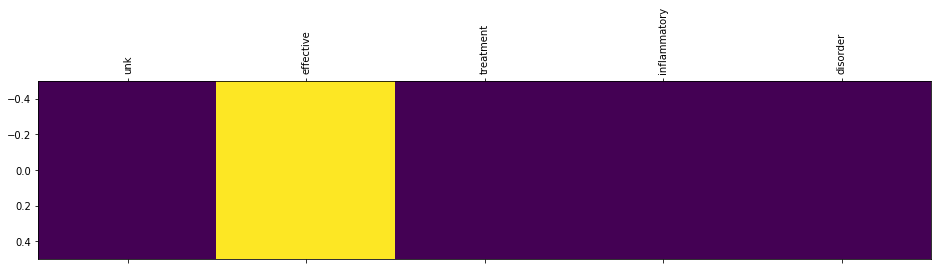

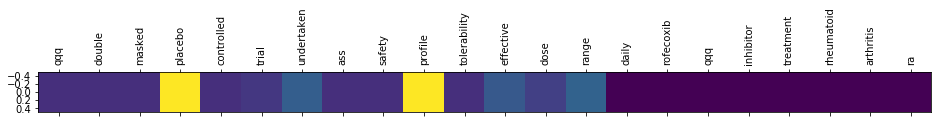

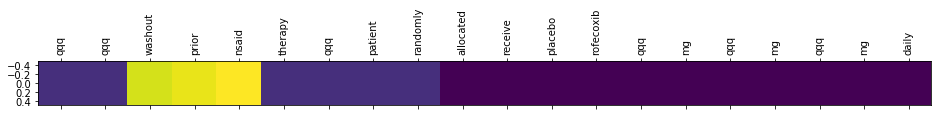

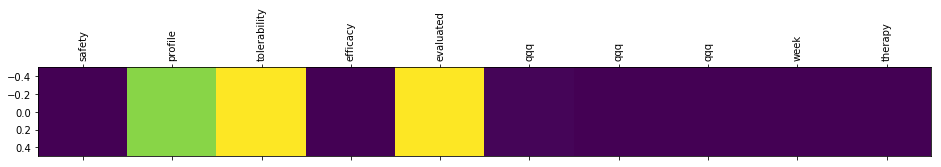

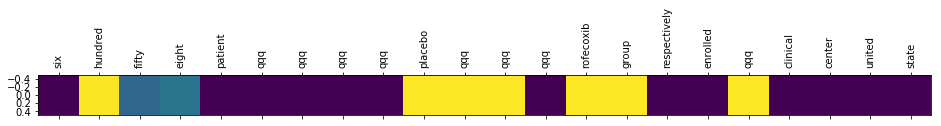

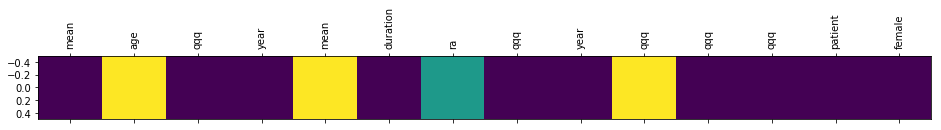

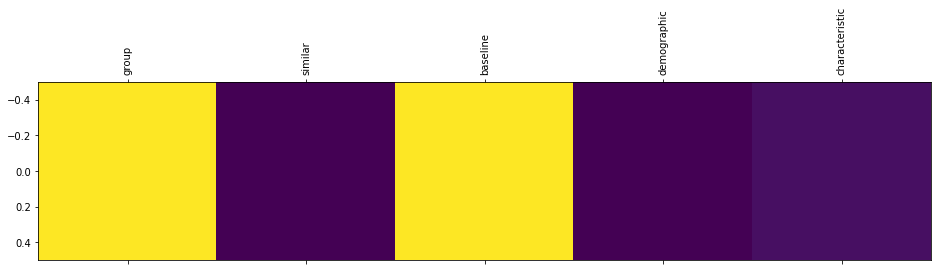

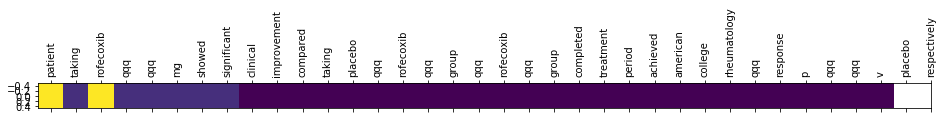

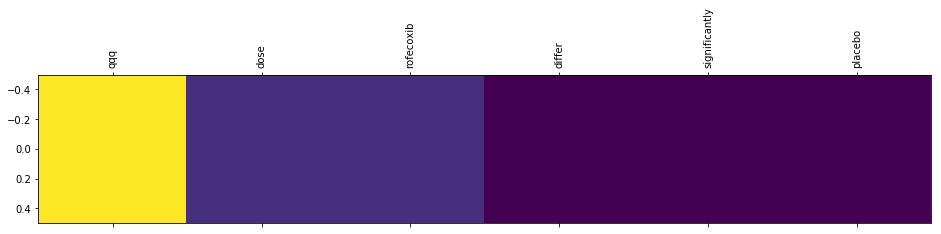

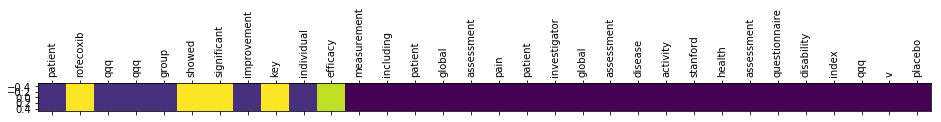

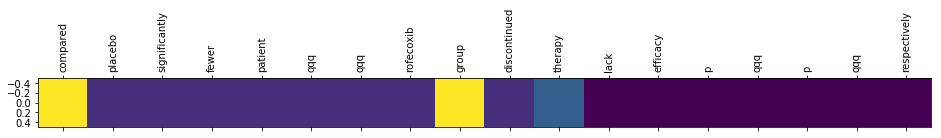

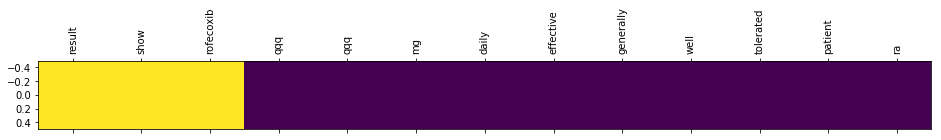

In [33]:
import matplotlib.pyplot as plt
for i, doc in enumerate(lang_1['cohen'][3:4]) :
    for j, sent in enumerate(doc) :
        w = attn[i][j].cpu().numpy()
        words = [lang_1['idx2word'][x] for x in sent]
        w = w[:len(words)]
        plt.matshow(w.T)
        plt.xticks(np.arange(len(words)), words, rotation=90)
        plt.show()